# General information
In this notebook, we explore the statistical distribution of the reference signal (`time_to_failure`) and the implications of chopping the signals in blocks of 150.000 samples.

# Preliminaries
Let's import everything we need:

In [1]:
import gc
import os
import time
import random
import datetime
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GridSearchCV, cross_val_score

Let's set some configurations

In [2]:
%matplotlib inline
pd.options.display.precision = 15
random.seed(6) #totally random seed (got from a dice)

# Training data
We load the raw input data as is.

In [3]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
fs = 4000000 #sampling frequency of the sensor signal

CPU times: user 2min 17s, sys: 4.65 s, total: 2min 22s
Wall time: 1h 8min 47s


In [4]:
print(f'Train: rows:{train.shape[0]} cols:{train.shape[1]}')

Train: rows:629145480 cols:2


Let's visualize the data

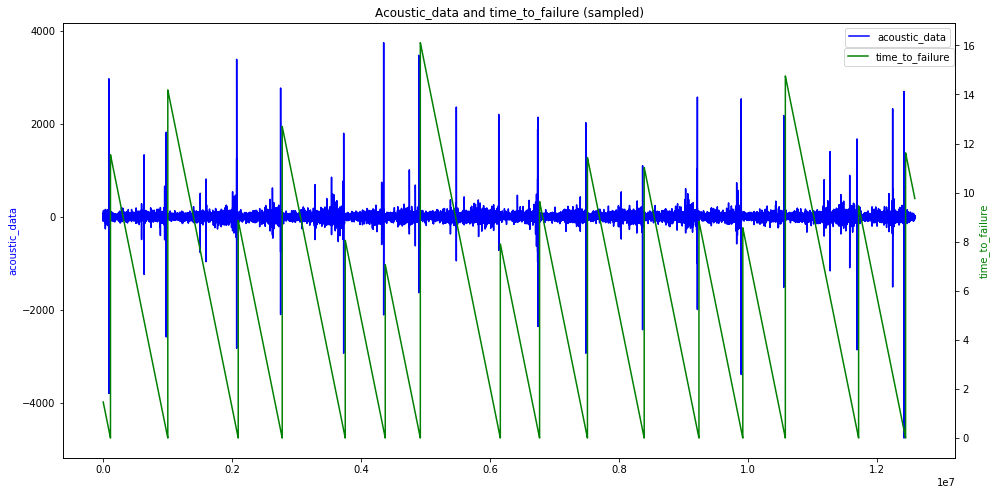

In [5]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('Acoustic_data and time_to_failure (sampled)')
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

It seems that the reference data (green line) won't be uniformly distributed. We can visualize it 

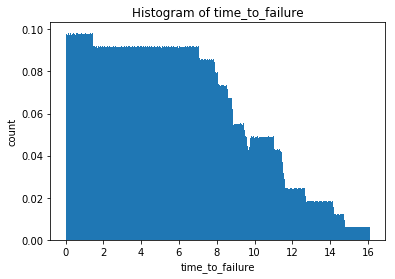

In [6]:
plt.figure()
plt.hist(train['time_to_failure'].values[::50], bins='auto', density=True)  # arguments are passed to np.histogram
plt.title('Histogram of time_to_failure')
plt.xlabel('time_to_failure')
plt.ylabel('count')
plt.show()

The time to training is not uniforally distribured on the training set. Resampling could be interesting.

# Sampling the training set
Since the testign set is build of sequences of 150.000 samples, let's chop the training set on comparable chunks. 

Several strategies of how to select the chunks are possible:
- Deterministic
- Random

Moreover, the *jumps* on the `time_to_failure` could be an issue (to be seen the impact). In this situation, we can
- Include the *jumps* on the training set
- Exlcude the *jumps* on the training set

Let's see what happens to the histogram in some of these situations:

In [7]:
# Create a training file with simple derived features
segment_size = 150000

In [8]:
def generate_segment_start_ids(sampling_method):
    """ Generates the indeces where the segments for the training data start """
    if sampling_method == 'uniform':
        # With this approach we obtain 4194 segments
        num_segments_training = int(np.floor(train.shape[0] / segment_size))
        segment_start_ids = [i * segment_size for i in range(num_segments_training)]
    elif sampling_method == 'uniform_no_jump':
        # With this approach we obtain 4178 segments (99.5% of 'uniform')
        already_sampled = np.full(train.shape[0], False)
        num_segments_training = int(np.floor(train.shape[0] / segment_size))
        time_to_failure_jumps = np.diff(train['time_to_failure'].values)
        num_good_segments_found = 0
        segment_start_ids = []
        for i in range(num_segments_training):
            idx = i * segment_size
            # Detect if there is a discontinuity on the time_to_failure signal within the segment
            max_jump = np.max(time_to_failure_jumps[idx:idx + segment_size])
            if max_jump < 5:
                segment_start_ids.append(idx)
                num_good_segments_found += 1
            else:
                print(f'Rejected candidate segment since max_jump={max_jump}')
        segment_start_ids.sort()
    elif sampling_method == 'random_no_jump':
        # With this approach we obtain 4194 segments
        num_segments_training = int(np.floor(train.shape[0] / segment_size)) #arbitrary choice
        time_to_failure_jumps = np.diff(train['time_to_failure'].values)
        num_good_segments_found = 0
        segment_start_ids = []
        while num_segments_training != num_good_segments_found:
            # Generate a random sampling position
            idx = random.randint(0, train.shape[0] - segment_size - 1)
            # Detect if there is a discontinuity on the time_to_failure signal within the segment
            max_jump = np.max(time_to_failure_jumps[idx:idx + segment_size])
            if max_jump < 5:
                segment_start_ids.append(idx)
                num_good_segments_found += 1
            else:
                print(f'Rejected candidate segment since max_jump={max_jump}')
        segment_start_ids.sort()
    else:
        raise NameError('Method does not exist')
    return segment_start_ids

Currently, we have three strategies implemented.
- Uniform sampling: Here the training set is built from consecutive chunks of data. No special care is taken into what's the content of each segment.
- Uniform sampling with rejection: Here the training set is built from consecutive chunks of data. There is a control to avoid having in a segment the jump of the `time_to_failure` signal from zero to a high value. *This is very dangerous when doing the splitting between training and validation*.
- Random sampling with rejection: Here the training set is built from sampling randomly the data. There is a control to avoid having in a segment the jump of the `time_to_failure` signal from zero to a high value. The segments will most likely overlap.

Let's visualize what happens to the distribution of the `time_to_failure` on teh different samplign strategies:

Generating uniformly sampled training set
Generating uniformly sampled training set excluding discontinuities in time_to_failure.
Rejected candidate segment since max_jump=11.54000473022461
Rejected candidate segment since max_jump=14.17990493774414
Rejected candidate segment since max_jump=8.855904579162598
Rejected candidate segment since max_jump=12.692904472351074
Rejected candidate segment since max_jump=8.05490493774414
Rejected candidate segment since max_jump=7.0579047203063965
Rejected candidate segment since max_jump=16.106904983520508
Rejected candidate segment since max_jump=7.904904365539551
Rejected candidate segment since max_jump=9.6369047164917
Rejected candidate segment since max_jump=11.425904273986816
Rejected candidate segment since max_jump=11.024004936218262
Rejected candidate segment since max_jump=8.828004837036133
Rejected candidate segment since max_jump=8.56590461730957
Rejected candidate segment since max_jump=14.750904083251953
Rejected candidate segment s

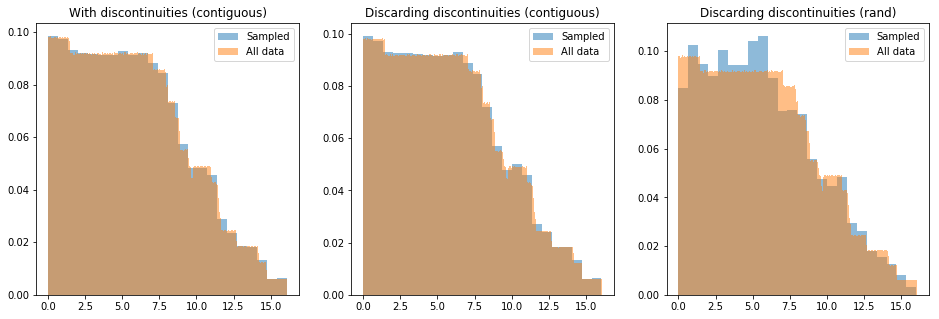

In [9]:
print(f'Generating uniformly sampled training set')
segment_start_ids_uniform = generate_segment_start_ids('uniform')

print(f'Generating uniformly sampled training set excluding discontinuities in time_to_failure.')
segment_start_ids_uniform_no_jump = generate_segment_start_ids('uniform_no_jump')

print(f'Generating randomly sampled training set excluding discontinuities in time_to_failure.')
print(f'This method may yield overlaping segments')
segment_start_ids_random_no_jump = generate_segment_start_ids('random_no_jump')


y_tr_samples_uniform = train['time_to_failure'].values[np.array(
    segment_start_ids_uniform) + segment_size - 1]
y_tr_samples_uniform_no_jump = train['time_to_failure'].values[
    np.array(segment_start_ids_uniform_no_jump) + segment_size - 1]
y_tr_samples_random_no_jump = train['time_to_failure'].values[
    np.array(segment_start_ids_random_no_jump) + segment_size - 1]

plt.subplots(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.hist(y_tr_samples_uniform, bins='auto', alpha=0.5, density=True)
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.title('With discontinuities (contiguous)')
plt.legend(['Sampled', 'All data'])

plt.subplot(1, 3, 2)
plt.hist(y_tr_samples_uniform_no_jump, bins='auto', alpha=0.5, density=True)
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.title('Discarding discontinuities (contiguous)')
plt.legend(['Sampled', 'All data'])

plt.subplot(1, 3, 3)
plt.hist(y_tr_samples_random_no_jump, bins='auto', alpha=0.5, density=True)
plt.title('Discarding discontinuities (rand)')
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.legend(['Sampled', 'All data'])
plt.show()

Here we conclude that the histogram of the `time_to_failure` does not change significantly when excluding *all* jumps. However, the histogram starts to be significantly distorded when randon sampling is applied.

[@konradb](https://www.kaggle.com/konradb), on a [post](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/85108#496570) on March 22ds, he pointed out that "By adjusting the median of my prediction to match the target, I got a boost both in cv (2.0702 -> 2.0538) and lb (1.512 -> 1.489)."
Let's explore what happens to the distribution when making a k-fold.

In [11]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 0 started at Fri Mar 22 16:38:57 2019


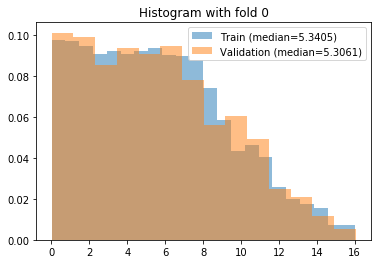

Fold 1 started at Fri Mar 22 16:38:57 2019


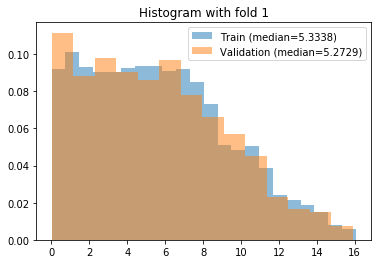

Fold 2 started at Fri Mar 22 16:38:57 2019


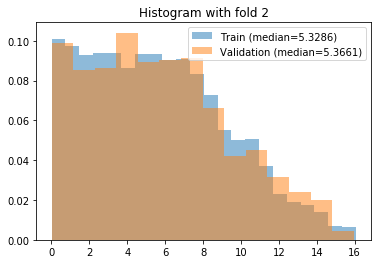

Fold 3 started at Fri Mar 22 16:38:57 2019


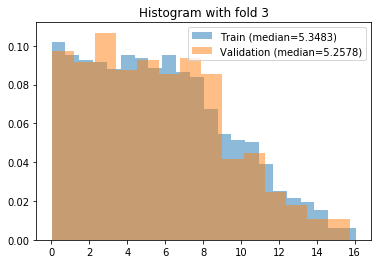

Fold 4 started at Fri Mar 22 16:38:57 2019


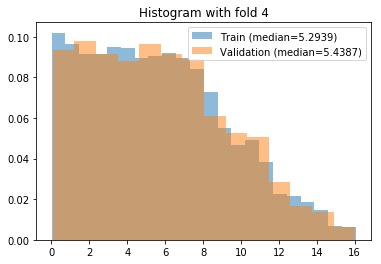

In [33]:
n_fold = folds.get_n_splits()

for fold_n, (train_index, valid_index) in enumerate(folds.split(y_tr_samples_uniform_no_jump)):
    print('Fold', fold_n, 'started at', time.ctime())
    y_train, y_valid = y_tr_samples_uniform_no_jump[train_index], y_tr_samples_uniform_no_jump[valid_index]

    plt.figure()
    plt.hist(y_train, bins='auto', alpha=0.5, density=True)
    plt.hist(y_valid, bins='auto', alpha=0.5, density=True)
    plt.title(f"Histogram with fold {fold_n}")
    plt.legend([f'Train (median={np.median(y_train):.4f})', f'Validation (median={np.median(y_valid):.4f})'])
    plt.show()

As we see here, the distributions of the training and validation datasets are not identical. It is to be seen if a more clever split can be done. 

Next questions to expore:
- For training, should we augment the dataset to have more equalized histogram?